In [27]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sys import float_info # Threshold smallest positive floating value
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn


x = torch.rand(5,3)

print(x)

tensor([[0.2736, 0.4269, 0.8768],
        [0.9911, 0.2734, 0.3690],
        [0.9112, 0.2487, 0.9186],
        [0.6662, 0.6771, 0.6101],
        [0.9566, 0.6707, 0.6336]])


In [28]:
# Generate Data Function - Returns N x 3 and labels
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

In [29]:
# ERM classification rule (min prob. of error classifier)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

In [30]:
# # Generate Training and Validation Datasets
# train_data_100, train_labels_100 = generate_data_from_gmm(100, gmm_pdf)
# train_data_200, train_labels_200 = generate_data_from_gmm(200, gmm_pdf)
# train_data_500, train_labels_500 = generate_data_from_gmm(500, gmm_pdf)
# train_data_1000, train_labels_1000 = generate_data_from_gmm(1000, gmm_pdf)
# train_data_2000, train_labels_2000 = generate_data_from_gmm(2000, gmm_pdf)
# train_data_5000, train_labels_5000 = generate_data_from_gmm(5000, gmm_pdf)
# validate_data_100000, validate_labels_100000 = generate_data_from_gmm(100000, gmm_pdf)

In [31]:
N = 500

n = 3 # dimensionality of input random vectors
C = 4 # number of classes

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([1/C, 1/C, 1/C, 1/C])

# Set mean vectors to be equally spaced out along a line in order
gmm_pdf['m'] = np.array([1*np.ones(n), 4*np.ones(n), 6*np.ones(n), 9*np.ones(n)])

# Set covariance matrices so that there is significant overlap between these
# distributions with means given above
gmm_pdf['C'] = np.array([2*np.eye(n), 2*np.eye(n), 2*np.eye(n), 2*np.eye(n)])

[117 121 150 112]


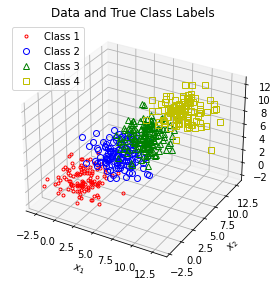

In [32]:
X, labels = generate_data_from_gmm(N, gmm_pdf)

L = np.array(range(C)) # Assuming 0-3 instead of 1-4 to make my life easier in Python

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

# Plot the original data and their true labels
fig = plt.figure()
ax_gmm = fig.add_subplot(111, projection='3d')


ax_gmm.plot(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2],'r.', label="Class 1", markerfacecolor='none')
ax_gmm.plot(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2],'bo', label="Class 2", markerfacecolor='none')
ax_gmm.plot(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2],'g^', label="Class 3", markerfacecolor='none')
ax_gmm.plot(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2],'ys', label="Class 4", markerfacecolor='none')
ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
# ax_gmm.set_aspect('equal')

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

In [33]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[109   3   0   0]
 [  8 104  17   0]
 [  0  14 128   3]
 [  0   0   5 109]]
Total Mumber of Misclassified Samples: 50
Empirically Estimated Probability of Error: 0.1000


In [34]:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class TwoLayerMLP(nn.Module):
    # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
    # the output when validating, on top of calculating the negative-log-likelihood using 
    # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
    
    def __init__(self, d_in, d_hidden, C):
        super(TwoLayerMLP, self).__init__()
        
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, C)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)  # fc to perceptrons
        x = self.relu(x) # or self.softplus(x) for smooth-ReLU, empirically worse than ReLU
        x = self.fc2(x)  # connect to output layer
        x = self.log_softmax(x)  # for outputs that sum to 1
        return x

In [35]:
model = TwoLayerMLP(X.shape[1], 16, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))


torch.Size([16, 3])
torch.Size([16])
torch.Size([4, 16])
torch.Size([4])
Total number of parameters = 132


In [36]:
def train_model(model, data, labels, criterion, optimizer, num_epochs=25):
    # Set up training data
    X_train = torch.FloatTensor(data)
    y_train = torch.LongTensor(labels)

    # Optimize the neural network
    for epoch in range(num_epochs):
        # Set grads to zero explicitly before backprop
        optimizer.zero_grad()
        outputs = model(X_train)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, y_train)
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

    return model

model = train_model(model, X, labels, criterion, optimizer, num_epochs=100)

In [115]:
def model_predict(model, data):
    # Set up test data as tensor
    X_test = torch.FloatTensor(data)

    # Evaluate nn on test data and compare to true labels
    predicted_labels = model(X_test)
    # Back to numpy
    predicted_labels = predicted_labels.detach().numpy()
    
    return np.argmax(predicted_labels, 1)

# Create coordinate matrices determined by the sample space
xx, yy, zz = np.meshgrid(np.linspace(-3, 3, 250), np.linspace(-3, 3, 250), np.linspace(-3, 3, 250))

grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

# Z matrix are the predictions resulting from softmax on the provided model parameters
Z = model_predict(model, grid).reshape(xx.shape)




In [ ]:
from sklearn.model_selection import KFold
k=10

splits=KFold(n_splits=k,shuffle=True,random_state=42)